$$
\newcommand{\Mm}{M}
\newcommand{\pideal}{\vec{p}}
%%\newcommand{\pideal}{\vec{p}_\text{ideal}}
\newcommand{\pnoisy}{\tilde{p}}
%%\newcommand{\pnoisy}{\vec{p}_\text{noisy}}
$$


# Readout error mitigation for the Sampler primitive using M3

*Estimated QPU usage: 1 minute (tested on IBM `ibm_kingston`)*

## Background

Unlike the Estimator primitive, the Sampler primitive does not have built-in support for error mitigation.
Several of the methods supported by the Estimator are specifically designed for expectation values, and hence are not applicable to the Sampler primitive.
However, readout error mitigation is a highly effective method that is also applicable to the Sampler primitive.
This tutorial explains how to use the [M3 Qiskit addon](https://qiskit.github.io/qiskit-addon-mthree/) to mitigate readout error for the Sampler primitive.

The M3 Qiskit addon implements an efficient method for readout error mitigation.

### What is readout error?

Immediately before measurement, the state of a qubit register is
described by a superposition of computational basis states,
or by a density matrix.
Measurement of the qubit register into a classical bit register then proceeds in two steps.
First the quantum measurement proper is performed.
This means that the state of the qubit register
is projected onto a single basis state that is characterized
by a string of $1$s and $0$s.
The second step consists of reading the bitstring characterizing this basis state
and writing it into classical computer memory.
We call this step *readout*.
It turns out that readout error is more important than error due to to incorrectly collapsing the state.
This makes sense when you recall that readout requires detecting a microscopic
quantum state and amplfying it to the macroscopic realm. A readout resonator is coupled to
the (transmon) qubit, thereby experiencing a very small frequency shift. A microwave pulse
is then bounced off of the resonator, in turn experiencing small changes in its
characteristics.  The reflected pulse is then amplified and analyzed.  This is a delicate
process subject to a host of errors.

The important point is that, while both quantum measurement and readout are subject to error, the
latter incurs the dominant error, called readout error.
In the following we be concerned only with readout error.

### Theoretical background

If the sampled bitstring (stored in classical memory) differs from the bitstring characterizing
the projected quantum state, we say that a readout error has occurred.
These errors are observed to be random and uncorrelated from sample to sample.
It has proven useful to model readout error as a _noisy classical channel_.
That is, for every pair of
bitstrings $i$ and $j$, there is fixed probability that a true value of $j$ will
be incorrectly read as $i$.

More precisely, for every pair of bitstrings $(i, j)$, there is a (conditional) probability $\Mm_{i,j}$
that $i$ is read, given that the true value is $j$.
That is,
$$
    \Mm_{i,j} =  \Pr(\text{readout value is } i | \text{true value is } j)
    \text{ for } i,j \in (0,...,2^n - 1), \tag{1}
$$
where $n$ is the number of bits in the readout register.
For concreteness, we assume that $i$ is a decimal integer whose binary representation is
the bitstring that labels the computational basis states.
We call the $2^n \times 2^n$ matrix $\Mm$ the _assignment matrix_.
For fixed true value $j$, summing the probability over all noisy outcomes $i$ must give one. That is
$$
    \sum_{i=0}^{2^n - 1} \Mm_{i,j} = 1 \text{ for all } j
$$
A matrix with no negative entries that satisfies (1) is called
_left-stochastic_.
A left-stochastic matrix is also called _column-stochastic_ because each of its columns sums to $1$.
We experimentally determine approximate values for each element $\Mm_{i,j}$ by
repeatedly preparing each basis state $|j \rangle$ and then computing the frequencies
of occurrence of sampled bitstrings.

If an experiment involves estimating a probability distribution over output bitstrings by repeated sampling,
then we can use $\Mm$ to mitigate readout error at the level of the distribution.
The first step is to repeat a fixed circuit of interest many times,
creating a histogram of sampled bitstrings.
The normalized histogram is the measured probability distribution over
the $2^n$ possible bitstrings, which we denote by $\pnoisy \in \mathbb{R}^{2^n}$.
The (estimated) probability ${\pnoisy}_i$ of sampling bitstring $i$
is equal to the sum over all true bitstrings $j$, each weighted by
the probability that it is mistaken for $i$.
This statement in matrix form is
$$
    \pnoisy = \Mm \pideal, \tag{2}
$$
where $\pideal$ is the true distribution. In words, the readout error has the effect of multiplying
the ideal distribution over bitstrings $\pideal$ by the assignment matrix $\Mm$ to
produce the observed distribution $\pnoisy$.
We have measured $\pnoisy$ and $\Mm$, but have no direct access to $\pideal$. In principle, we will
obtain the true distribution of bitstrings for our circuit
by solving equation (2) for $\pideal$ numerically.

Before we move on, it's worth noting some important features of this naive approach.

- In practice, equation (2) is not solved by inverting $\Mm$. Linear algebra
  routines in software libraries employ methods that are more stable, accurate, and efficient.
- When estimating $\Mm$, we assumed that only readout errors occurred. In particular,
  we assume there were no state preparation and quantum measurement errors—
  or at least that they were otherwise mitigated.
  To the extent that this is a good assumption, $\Mm$ really represents
  only readout error. But when we _use_ $\Mm$ to correct a measured distribution
  over bitstrings, we make no such assumption. In fact, we expect an interesting
  circuit to introduce noise, for instance, gate errors. The "true" distribution
  still includes effects from any errors that are not otherwise mitigated.

This method, while useful in some circumstances, suffers from a few limitations.

The space and time resources needed to estimate $\Mm$ grow exponentially in $n$:
- The estimation of $\Mm$ and $\pnoisy$ is subject to statistical error due to finite sampling.
  This noise can be made as small as desired
  at the cost of more shots (up to the timescale of drifting hardware parameters
  that result in systematic errors in $\Mm$.)
  However, if no assumptions are made on the bitstrings observed
  when performing mitigation, the number of shots required to estimate $\Mm$ grows
  at least exponentially in $n$.
- $\Mm$ is a $2^n \times 2^n$ matrix.
  When $n>10$, the amount of memory required to store $\Mm$ is
  greater than the memory available in a powerful laptop.

Further limitations are:

- The recovered distribution $\pideal$ may have one
  or more negative probabilities (while still summing to one). One solution
  is to minimize $||\Mm \pideal - \pnoisy||^2$ subject to the constraint that
  each entry in $\pideal$ be non-negative. However, the runtime of such a
  method is orders of magnitude longer than directly solving equation (2).
- This mitigation procedure works on the level of a probability distribution
  over bitstrings. In particular, it cannot correct an error in an individual
  observed bitstring.

### Qiskit M3 addon: Scaling to longer bitstrings

The M3 method is an alternative to direct solution of equation (2)
for mitigating readout error in the experimental distribution over bitstrings.
While the direct method is limited to bitstrings no longer than about $10$ bits,
M3 can handle much longer bitstrings.
The two important features of M3 are
- Correlations in readout error of order three and higher among collections of bits
  are assumed to be negligible and are ignored. In principle, at the cost of more shots,
  one could estimate higher correlations as well.
- Rather than constructing $\Mm$ explicitly, we use a much smaller effective matrix that records
  probabilities only for bitstrings collected when constructing $\pnoisy$.

At a high level, the procedure works as follows.

First, we construct building blocks from which we can construct a simplified, effective, description of $\Mm$.
Then, we repeatedly run the circuit of interest and collect bitstrings which we use to construct
both $\pnoisy$ and, with the help of the building blocks, an effective $\Mm$.

More precisely,
- Single-qubit assignment matrices are estimated for each qubit. To do this, we repeatedly
  prepare the qubit register in the all-zero state $|0 ... 0 \rangle$ and then in the all-one
  state $|1 ... 1 \rangle$, and record the probability for each qubit that it is read
  incorrectly.
- Correlations of order three and higher are assumed to be negligible and are ignored.

  Instead we construct a number $n$ of $2 \times 2$ single qubit
  assignment matrices, and a number $n(n-1)/2$ of $4 \times 4$ two-qubit assignment
  matrices. These one- and two-qubit assignment matrices are stored for later
  use.
- After repeatedly sampling a circuit to construct $\pnoisy$,
  we construct an effective approximation to $\Mm$ using only
  bitstrings that are sampled when constructing $\pnoisy$. This effective matrix
  is built using the one- and two-qubit matrices described in the previous item.
  The linear dimension of this matrix is at most of the order of the number
  of shots used in constructing $\pnoisy$, which is much smaller than
  the dimension $2^n$ of the full assignment matrix $\Mm$ .

For technical details on M3, you can refer to [*Scalable Mitigation of Measurement Errors on Quantum Computers*](https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.2.040326).

### Application of M3 to a quantum algorithm
We'll apply M3's readout mitigation to the hidden shift problem. The hidden shift problem, and closely related problems such as the [hidden subgroup problem](https://en.wikipedia.org/wiki/Hidden_subgroup_problem), were originally conceived in a fault-tolerant setting (more precisely, before fault-tolerant QPUs were proved to be possible!). But they are studied with available processors as well. An example of algorithmic exponential speedup obtained for a variant of the hidden shift problem obtained on 127-qubit IBM QPU's can be found in [this paper](https://journals.aps.org/prx/accepted/a9074K06A8e1590147da9c69f8c4b64c28247be5a) ([arXiv version](https://arxiv.org/abs/2401.07934)).

$$
% Define CZ as a math operator
\DeclareMathOperator{\CZ}{CZ}
\newcommand{\bra}[1]{\langle #1|}
\newcommand{\ket}[1]{|#1\rangle}
\newcommand{\braket}[2]{\langle #1|#2\rangle}
\newcommand{\ketbra}[2]{|#1\rangle\langle#2|}
\newcommand{\Zgr}{\mathbb{Z}_2^n}
\newcommand{\Zgrm}{\mathbb{Z}_2^m}
$$

In the following, all arithmetic is Boolean.
That is, for $a, b \in \mathbb{Z}_2 = \{0, 1\}$, addition, $a + b$ is the logical XOR function.
Furthermore, multiplication $a \times b$ (or $a b$) is the logical AND function. For $x, y \in \{0, 1\}^n$,
$x + y$ is defined by bitwise application of XOR.
The dot product $\cdot: \Zgr \rightarrow \mathbb{Z}_2$ is defined
by $x \cdot y = \sum_i x_i y_i$.

#### Hadamard operator and Fourier transform

In implementing quantum algorithms, it is very common to use the Hadamard operator as a Fourier transform.
The computational basis states are sometimes called _classical states_. They stand in
a one-to-one relation to the classical bitstrings.
The $n$-qubit Hadamard operator on classical states can be viewed as a Fourier transform on the Boolean hypercube:
$$
H^{\otimes n} =  \frac{1}{\sqrt{2^n}} \sum_{x,y \in \Zgr} (-1)^{x \cdot y} \ket{y}\bra{x}.
$$
Consider a state $\ket{s}$ corresponding to fixed bitstring $s$.
Applying $H^{\otimes n}$, and using $\braket{x}{s} = \delta_{x,s}$,
we see that the Fourier transform of $\ket{s}$ can be written
$$
   H^{\otimes n} \ket{s} =  \frac{1}{\sqrt{2^n}} \sum_{y \in \Zgr} (-1)^{s \cdot y} \ket{y}.
$$

The Hadamard is its own inverse, that is,
 $H^{\otimes n} H^{\otimes n} = (H H)^{\otimes n} = I^{\otimes n}$.
Thus, the inverse Fourier transform is the same operator, $H^{\otimes n}$.
Explicitly, we have,
$$
  \ket{s} =  H^{\otimes n} H^{\otimes n} \ket{s}  =  H^{\otimes n} \frac{1}{\sqrt{2^n}} \sum_{y \in \Zgr} (-1)^{s \cdot y} \ket{y}.
$$

#### The hidden shift problem

$$
\newcommand{\ffunc}{f}
$$

We consider a simple example of a _hidden shift problem_.
The problem is to identify a constant shift in the input to a function.
The function we consider is the dot product. It is the simplest member
of a large class of functions that admit a quantum speedup for the hidden shift
problem via techniques similar to those presented below.

Let $x,y \in \Zgrm$ be bitstrings of length $m$.
We define $\ffunc: \Zgrm \times \Zgrm \rightarrow \{-1,1\}$ by
$$
  \ffunc(x, y) = (-1)^{x \cdot y}.
$$
  Let $a,b \in \Zgrm$ be fixed bitstrings of length $m$.
  We furthermore define $g: \Zgrm \times \Zgrm \rightarrow \{-1,1\}$ by
$$
  g(x, y) = \ffunc(x+a, y+b) = (-1)^{(x+a) \cdot (y+b)},
  $$
  where $a$ and $b$ are (hidden) parameters.
  We are given two black boxes, one implementing $f$, and the other $g$.
  We suppose that we know that they compute the functions defined above, except that we know
  neither $a$ nor $b$. The game is to determine the hidden bitstrings (shifts)
  $a$ and $b$ by making queries to $f$ and $g$. It's clear that if we play the game classically,
  we need $O(2m)$ queries to determine $a$ and $b$. For example, we can query $g$
  with all pairs of strings that combined have exactly one element set to $1$.
  On each query, we learn one element of either $a$ or $b$.
  However, we will see that, if the black boxes are implemented as quantum circuits, we can
  determine $a$ and $b$ with a single query to each of $f$ and $g$.

  In the context of algorithmic complexity, a black box is called an _oracle_.
  In addition to being opaque, an oracle has the property that it consumes the input and
  produces the output instantly, adding nothing to the complexity budget of the algorithm
  in which it is embedded. In fact, in the case at hand, the oracles implementing $f$ and
  $g$ will be seen to be efficient.

#### Quantum circuits for $f$ and $g$

We will need the following ingredients in order to implement $f$ and $g$ as quantum circuits.

For single qubit classical states $\ket{x_1}, \ket{y_1}$, with $x_1,y_1 \in \mathbb{Z}_2$,
the controlled $Z$ gate $\CZ$ may be written
\begin{equation}
\CZ \ket{x_1}\ket{y_1} = (-1)^{x_1 y_1} \ket{x_1}\ket{y_1}.
\end{equation}
We will operate with $m$ CZ gates, one on $(x_1, y_1)$, and one on $(x_2, y_2)$, and so on, through $(x_m, y_m)$.
We call this operator $\CZ_{x,y}$.

$U_f = \CZ_{x,y}$ is a quantum version of $\ffunc = \ffunc(x,y)$:
$$
%\CZ_{x,y} \ket{z} =
U_f \ket{x}\ket{y} = \CZ_{x,y} \ket{x}\ket{y} = (-1)^{x \cdot y}  \ket{x}\ket{y}.
$$

We also need to implement a bitstring shift.
We denote the operator on the $x$ register $X^{a_1}\cdots X^{a_m}$ by $X_a$
and likewise on the $y$ register $X_b =  X^{b_1}\cdots X^{b_m}$.
These operators apply $X$ wherever a single bit is $1$, and the identity $I$ wherever it is $0$.
Then we have
$$
 X_a X_b  \ket{x}\ket{y} = \ket{x+a}\ket{y+b}.
$$

The second black box $g$ is implemented by the unitary $U_g$, given by
$$
%U_g \ket{x}\ket{y} = X_aX_b \CZ_{x,y} X_aX_b \ket{x}\ket{y}.
U_g = X_aX_b \CZ_{x,y} X_aX_b.
$$
To see this, we apply the operators from right to left to the state $\ket{x}\ket{y}$.
First
$$
\begin{equation}
 X_a X_b  \ket{x}\ket{y} = \ket{x+a}\ket{y+b}.
\end{equation}
$$
Then,
$$
\begin{equation}
  \CZ_{x,y}  \ket{x+a}\ket{y+b} = (-1)^{(x+a)\cdot (y+b)} \ket{x+a}\ket{y+b}
\end{equation}
$$
Finally,
$$
\begin{equation}
  X^a X^b (-1)^{(x+a)\cdot (y+b)} \ket{x+a}\ket{y+b} = (-1)^{(x+a)\cdot (y+b)} \ket{x}\ket{y},
\end{equation}
$$
which is indeed the quantum version of $f(x+a, y+b)$.

#### The hidden shift algorithm

$$
\newcommand{\kzero}{\ket{0}^{\otimes m}}
$$

Now we put the pieces constructed above together to solve the hidden shift problem.
We begin by applying Hadamards to the registers initialized to the all-zero state.
$$
H^{\otimes 2m} = H^{\otimes m} \otimes H^{\otimes m} \kzero\kzero = \frac{1}{\sqrt{2^{2m}}} \sum_{x, y \in \Zgrm} (-1)^{x \cdot y} \ket{x}\ket{y}.
$$
 Next, we query the oracle $g$ to arrive at
 $$
 U_g H^{\otimes 2m} \kzero\kzero
 = \frac{1}{\sqrt{2^{2m}}} \sum_{x, y \in \Zgrm} (-1)^{(x+a) \cdot (y+b)} \ket{x}\ket{y}
 $$
 $$
 \approx \frac{1}{\sqrt{2^{2m}}} \sum_{x, y \in \Zgrm} (-1)^{x \cdot y + x \cdot b + y \cdot a} \ket{x}\ket{y}.
 $$
 In the last line, we omitted the constant global phase factor $(-1)^{a \cdot b}$,
 and denote equality up to a phase by $\approx$.
 Next, applying the oracle $f$ introduces another factor of $(-1)^{x \cdot y}$, canceling the one already
 present. We then have,
 $$
 U_f U_g H^{\otimes 2m} \kzero\kzero
 \approx \frac{1}{\sqrt{2^{2m}}} \sum_{x, y \in \Zgrm} (-1)^{x \cdot b + y \cdot a} \ket{x}\ket{y}.
 $$
 The final step is to apply the inverse Fourier transform, $H^{\otimes 2m} = H^{\otimes m} \otimes H^{\otimes m}$,
 resulting in
 $$
 H^{\otimes 2m} U_f U_g  H^{\otimes 2m} \kzero\kzero
 \approx \ket{b}\ket{a}.
 $$
 The circuit is finished. In the absence of noise, sampling the quantum registers will
 return the bitstrings $b, a$ with probability one.

The Boolean inner product is an example of the so-called bent functions.
We will not define bent functions here
but merely note that they
``are maximally resistant against attacks that seek to exploit a dependence of
the outputs on some linear subspace of the inputs.''
This quote is from the article [_Quantum algorithms for highly non-linear Boolean functions_](https://arxiv.org/abs/0811.3208), which
gives efficient hidden-shift algorithms for several classes of bent functions.
The algorithm in this tutorial appears in Section 3.1 of the article.

In the more general case, the circuit for finding a hidden shift $s \in \mathbb{Z}^n$ is
$$
 H^{\otimes n} U_{\tilde{f}}  H^{\otimes n} U_g  H^{\otimes n} \ket{0}^{\otimes n} = \ket{s}.
$$
 In the general case, $f$ and $g$ are functions of a single variable.
 Our example of the inner product has this form if we let $f(x, y) \to f(z)$,
 with $z$ equal to the concatenation of $x$ and $y$, and $s$ equal to the concatenation
 of $a$ and $b$.
 The general case requires exactly two oracles: One oracle for $g$ and one for $\tilde{f}$,
 where the latter is a function known as the _dual_ of the bent function $f$.
 The inner product function has the self-dual property $\tilde{f}=f$.

 In our circuit for the hidden shift on the inner product we omitted the middle layer
 of Hadamards that appears in the circuit for the general case. While in the general case
 this layer is necessary, we saved a bit of depth by omitting it, at the expense of a bit
 of post-processing because the output is $\ket{b}\ket{a}$ instead of the desired $\ket{a}\ket{b}$.



## Requirements

Before starting this tutorial, ensure that you have the following installed:

- Qiskit SDK 2.1 or later with visualization support (`pip install 'qiskit[visualization]'`)
- Qiskit Runtime 0.41 or later (`pip install qiskit-ibm-runtime`)
- M3 Qiskit addon 3.0 (`pip install mthree`)

## Setup


## Step 1: Map classical inputs to a quantum problem



First, we write the functions to implement the hidden shift problem as a `QuantumCircuit`.

In [1]:
from collections.abc import Iterator, Sequence
from random import Random

from qiskit.circuit import CircuitInstruction, QuantumCircuit, QuantumRegister, Qubit
from qiskit.circuit.library import CZGate, HGate, XGate


def apply_hadamards(qubits: Sequence[Qubit]) -> Iterator[CircuitInstruction]:
    """Apply a Hadamard gate to every qubit."""
    for q in qubits:
        yield CircuitInstruction(HGate(), [q], [])


def apply_shift(qubits: Sequence[Qubit], shift: int) -> Iterator[CircuitInstruction]:
    """Apply X gates where the bits of the shift are equal to 1."""
    for i, q in zip(range(shift.bit_length()), qubits):
        if shift >> i & 1:
            yield CircuitInstruction(XGate(), [q], [])


def oracle_f(qubits: Sequence[Qubit]) -> Iterator[CircuitInstruction]:
    """Apply the f oracle."""
    for i in range(0, len(qubits) - 1, 2):
        yield CircuitInstruction(CZGate(), [qubits[i], qubits[i + 1]])


def oracle_g(qubits: Sequence[Qubit], shift: int) -> Iterator[CircuitInstruction]:
    """Apply the g oracle."""
    yield from apply_shift(qubits, shift)
    yield from oracle_f(qubits)
    yield from apply_shift(qubits, shift)


def determine_hidden_shift(
    qubits: Sequence[Qubit], shift: int
) -> Iterator[CircuitInstruction]:
    """Determine the hidden shift."""
    yield from apply_hadamards(qubits)
    yield from oracle_g(qubits, shift)
    # We omit this layer in exchange for post processing
    # yield from apply_hadamards(qubits)
    yield from oracle_f(qubits)
    yield from apply_hadamards(qubits)
def run_hidden_shift_circuit(n_qubits, rng):
    hidden_shift = rng.getrandbits(n_qubits)

    qubits = QuantumRegister(n_qubits, name="q")
    circuit = QuantumCircuit.from_instructions(
        determine_hidden_shift(qubits, hidden_shift), qubits=qubits
    )
    circuit.measure_all()
    # Format the hidden shift as a string.
    hidden_shift_string = format(hidden_shift, f"0{n_qubits}b")
    return (circuit, hidden_shift, hidden_shift_string)

def display_circuit(circuit):
    return circuit.remove_final_measurements(inplace=False).draw(
        "mpl", idle_wires=False, scale=0.5, fold=-1
    )

We'll start with a fairly small example:

Hidden shift string 011010


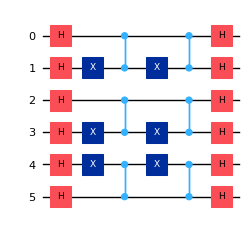

In [2]:
n_qubits = 6
random_seed = 12345
rng = Random(random_seed)
circuit, hidden_shift, hidden_shift_string = run_hidden_shift_circuit(n_qubits, rng)

print(f"Hidden shift string {hidden_shift_string}")

display_circuit(circuit)

## Step 2: Optimize circuits for quantum hardware execution

In [3]:
job_tags = [f'shift {hidden_shift_string}', f'n_qubits {n_qubits}', f'seed = {random_seed}']
job_tags

['shift 011010', 'n_qubits 6', 'seed = 12345']

Using backend ibm_kingston


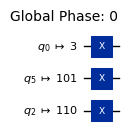

In [4]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService

# Uncomment this to run the circuits on a quantum computer on IBMCloud.
service = QiskitRuntimeService()
backend = service.backend("ibm_kingston")

# from qiskit_ibm_runtime.fake_provider import FakeMelbourneV2
# backend = FakeMelbourneV2()
# backend.refresh(service)

print(f"Using backend {backend.name}")

def get_isa_circuit(circuit, backend):
    pass_manager = generate_preset_pass_manager(
        optimization_level=3, backend=backend, seed_transpiler=1234
    )
    isa_circuit = pass_manager.run(circuit)
    return isa_circuit

isa_circuit = get_isa_circuit(circuit, backend)
display_circuit(isa_circuit)

## Step 3: Execute circuits using Qiskit Primitives

In [5]:
# submit job for solving the hidden shift problem using the Sampler primitive
NUM_SHOTS = 50_000

from qiskit_ibm_runtime import SamplerV2 as Sampler
def run_sampler(backend, isa_circuit, num_shots):
    sampler = Sampler(mode=backend)
    sampler.options.environment.job_tags
    pubs = [(isa_circuit, None, NUM_SHOTS)]
    job = sampler.run(pubs)
    return job

import mthree

def setup_mthree_mitigation(isa_circuit, backend):
    # retrieve the final qubit mapping so mthree knows which qubits to calibrate
    qubit_mapping = mthree.utils.final_measurement_mapping(isa_circuit)

    # submit jobs for readout error calibration
    mit = mthree.M3Mitigation(backend)
    mit.cals_from_system(qubit_mapping, rep_delay=None)

    return mit, qubit_mapping

In [6]:
job = run_sampler(backend, isa_circuit, NUM_SHOTS)
mit, qubit_mapping = setup_mthree_mitigation(isa_circuit, backend)

## Step 4: Post-process and return results in classical format

In the theoretical discussion above, we determined that for input $ab$, we expect output $ba$.
An additional complication is that, in order to have a simpler (pre-transpiled) circuit, we inserted the required CZ gates between
neighboring pairs of qubits. This amounts to interleaving the bitstrings $a$ and $b$ as $a1 b1 a2 b2 \ldots$.
The output string $ba$ will be interleaved in a similar way: $b1 a1 b2 a2 \ldots$. The function `unscramble` below
transforms the output string from $b1 a1 b2 a2 \ldots$ to $a1 b1 a2 b2 \ldots$ so that the input and output strings may be compared directly.


In [7]:
# retrieve bitstring counts
def get_bitstring_counts(job):
    result = job.result()
    pub_result = result[0]
    counts = pub_result.data.meas.get_counts()
    return counts, pub_result

In [8]:
counts, pub_result = get_bitstring_counts(job)

The Hamming distance between two bit strings is the number of indices at which the bits differ.

In [9]:
def hamming_distance(s1, s2):
    weight = 0
    for c1, c2 in zip(s1, s2):
        (c1, c2) = (int(c1), int(c2))
        if (c1 == 1 and c2 == 1) or (c1 == 0 and c2 == 0):
            weight += 1

    return weight

In [10]:
# Replace string of form a1b1a2b2... with b1a1b2a1...
# That is, reverse order of successive pairs of bits.
def unscramble(bitstring):
    ps = [bitstring[i:i+2][::-1] for i in range(0, len(bitstring), 2)]
    return "".join(ps)

def find_hidden_shift_bitstring(counts, hidden_shift_string):
    # convert counts to probabilities
    probs = {unscramble(bitstring): count / NUM_SHOTS for bitstring, count in counts.items()}

    # Retrieve the most probable bitstring.
    most_probable = max(probs, key=lambda x: probs[x])

    print(f"Expected hidden shift string: {hidden_shift_string}")
    if most_probable == hidden_shift_string:
        print("Most probable bitstring matches hidden shift 😊.")
    else:
        print("Most probable bitstring didn't match hidden shift ☹️.")
    print("Top 10 bitstrings and their probabilities:")
    display({k: (v, hamming_distance(hidden_shift_string, k)) for k, v in sorted(probs.items(), key=lambda x: x[1], reverse=True)[:10]})

    return probs, most_probable

In [11]:
probs, most_probable = find_hidden_shift_bitstring(counts, hidden_shift_string)

Expected hidden shift string: 011010
Most probable bitstring matches hidden shift 😊.
Top 10 bitstrings and their probabilities:


{'011010': (0.9743, 6),
 '001010': (0.00812, 5),
 '010010': (0.0063, 5),
 '011000': (0.00554, 5),
 '011011': (0.00492, 5),
 '011110': (0.00044, 5),
 '001000': (0.00012, 4),
 '010000': (8e-05, 4),
 '001011': (6e-05, 4),
 '000010': (6e-05, 4)}

Let's record the probability of the most probable bitstring before applying readout error mitigation with M3.

In [12]:
max_probability_before_M3 = probs[most_probable]
max_probability_before_M3

0.9743

Now we apply the readout correction learned by M3 to the counts.
The function `apply_corrections` returns a quasi-probability distribution. This is a list of `float`s that sum to one. But some values might be negative.

In [13]:
def perform_mitigation(mit, counts, qubit_mapping):

    # mitigate readout error
    quasis = mit.apply_correction(counts, qubit_mapping)
    
    # print results
    most_probable_after_m3 = unscramble(max(quasis, key=lambda x: quasis[x]))
    
    is_hidden_shift_identified = most_probable_after_m3 == hidden_shift_string
    if is_hidden_shift_identified:
        print("Most probable bitstring matches hidden shift 😊.")
    else:
        print("Most probable bitstring didn't match hidden shift ☹️.")
    print("Top 10 bitstrings and their quasi-probabilities:")
    topten = {unscramble(k): f"{v:.2e}" for k, v in sorted(quasis.items(), key=lambda x: x[1], reverse=True)[:10]}
    max_probability_after_M3 = float(topten[most_probable_after_m3])
    display(topten)

    return max_probability_after_M3, is_hidden_shift_identified

In [14]:
print(f"Expected hidden shift string: {hidden_shift_string}")
max_probability_after_M3, is_hidden_shift_identified =perform_mitigation(mit, counts, qubit_mapping)

Expected hidden shift string: 011010
Most probable bitstring matches hidden shift 😊.
Top 10 bitstrings and their quasi-probabilities:


{'011010': '1.01e+00',
 '001010': '8.75e-04',
 '001000': '7.38e-05',
 '010000': '4.51e-05',
 '111000': '2.18e-05',
 '001011': '1.74e-05',
 '000010': '6.42e-06',
 '011001': '-7.18e-06',
 '011000': '-4.53e-04',
 '010010': '-1.28e-03'}

#### Comparing identifying the hidden shift string before and after applying M3 correction

In [15]:
def compare_before_and_after_M3(max_probability_before_M3, max_probability_after_M3, is_hidden_shift_identified):

    is_probability_improved = max_probability_after_M3 > max_probability_before_M3
    print(f"Most probable probability before M3: {max_probability_before_M3}")
    print(f"Most probable probability after M3: {max_probability_after_M3}")
    if is_hidden_shift_identified and is_probability_improved:
        print("Readout error mitigation effective! 😊")
    else:
        print("Readout error mitigation not effective. ☹️")

In [16]:
compare_before_and_after_M3(max_probability_before_M3, max_probability_after_M3, is_hidden_shift_identified)

Most probable probability before M3: 0.9743
Most probable probability after M3: 1.01
Readout error mitigation effective! 😊


### Plot how CPU time required by M3 scales with shots

Applying M3 correction to 5000 shots...
	Done in 0.003321983851492405 seconds.
Applying M3 correction to 7500 shots...
	Done in 0.004425413906574249 seconds.
Applying M3 correction to 10000 shots...
	Done in 0.006366567220538855 seconds.
Applying M3 correction to 12500 shots...
	Done in 0.0071477219462394714 seconds.
Applying M3 correction to 15000 shots...
	Done in 0.00860048783943057 seconds.
Applying M3 correction to 17500 shots...
	Done in 0.010026784148067236 seconds.
Applying M3 correction to 20000 shots...
	Done in 0.011459112167358398 seconds.
Applying M3 correction to 22500 shots...
	Done in 0.012727141845971346 seconds.
Applying M3 correction to 25000 shots...
	Done in 0.01406092382967472 seconds.
Applying M3 correction to 27500 shots...
	Done in 0.01546052098274231 seconds.
Applying M3 correction to 30000 shots...
	Done in 0.016769016161561012 seconds.
Applying M3 correction to 32500 shots...
	Done in 0.019537431187927723 seconds.
Applying M3 correction to 35000 shots...
	Do

Text(0.5, 1.0, 'Time to apply M3 correction')

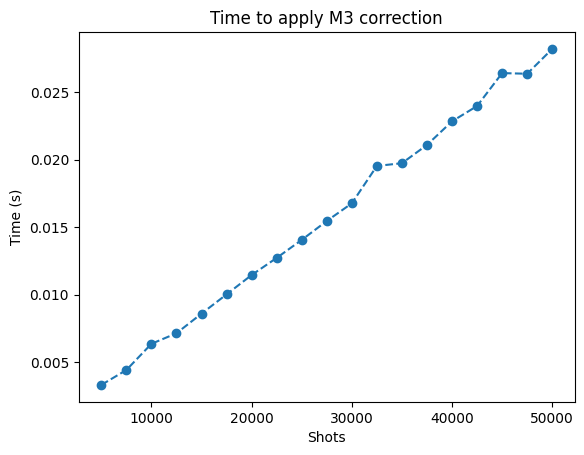

In [17]:
import timeit

import matplotlib.pyplot as plt

# Collect samples for numbers of shots varying from 5000 to 25000.
shots_range = range(5000, NUM_SHOTS+1, 2500)
times = []
for shots in shots_range:
    print(f"Applying M3 correction to {shots} shots...")
    t0 = timeit.default_timer()
    _ = mit.apply_correction(
        pub_result.data.meas.slice_shots(range(shots)).get_counts(), qubit_mapping
    )
    t1 = timeit.default_timer()
    print(f"\tDone in {t1 - t0} seconds.")
    times.append(t1 - t0)

fig, ax = plt.subplots()
ax.plot(shots_range, times, "o--")
ax.set_xlabel("Shots")
ax.set_ylabel("Time (s)")
ax.set_title("Time to apply M3 correction")

#### Interpreting the plot

The plot above shows that the time required to apply M3 correction scales linearly in the number of shots.

# Scaling up!

In [18]:
n_qubits = 80
rng = Random(12345)
circuit, hidden_shift, hidden_shift_string = run_hidden_shift_circuit(n_qubits, rng)

print(f"Hidden shift string {hidden_shift_string}")

Hidden shift string 00000010100110101011101110010001010000110011101001101010101001111001100110000111


In [19]:
isa_circuit = get_isa_circuit(circuit, backend)

In [20]:
job = run_sampler(backend, isa_circuit, NUM_SHOTS)
mit, qubit_mapping = setup_mthree_mitigation(isa_circuit, backend)

In [21]:
counts, pub_result = get_bitstring_counts(job)

In [22]:
probs, most_probable = find_hidden_shift_bitstring(counts, hidden_shift_string)

Expected hidden shift string: 00000010100110101011101110010001010000110011101001101010101001111001100110000111
Most probable bitstring matches hidden shift 😊.
Top 10 bitstrings and their probabilities:


{'00000010100110101011101110010001010000110011101001101010101001111001100110000111': (0.50402,
  80),
 '00000010100110101011101110010001010000110011100001101010101001111001100110000111': (0.0396,
  79),
 '00000010100110101011101110010001010000110011101001101010101001111001100100000111': (0.0323,
  79),
 '00000010100110101011101110010001010000110011101001101010101001101001100110000111': (0.01936,
  79),
 '00000010100110101011101110010011010000110011101001101010101001111001100110000111': (0.01432,
  79),
 '00000010100110101011101110010001010000110011101001101010101001011001100110000111': (0.0101,
  79),
 '00000010100110101011101110010001010000110011101001101010101001110001100110000111': (0.00924,
  79),
 '00000010100110101011101110010001010000010011101001101010101001111001100110000111': (0.00908,
  79),
 '00000010100110101011100110010001010000110011101001101010101001111001100110000111': (0.00888,
  79),
 '00000010100110101011101110010001010000110011101001100010101001111001100110000111': 

We see that the correct hidden shift string is found. Furthermore, the nine next-most-probably bitstrings arewrong in only one position.

Record the most probable probability

In [23]:
max_probability_before_M3 = probs[most_probable]
max_probability_before_M3

0.50402

In [24]:
print(f"Expected hidden shift string: {hidden_shift_string}")
max_probability_after_M3, is_hidden_shift_identified =perform_mitigation(mit, counts, qubit_mapping)

Expected hidden shift string: 00000010100110101011101110010001010000110011101001101010101001111001100110000111
Most probable bitstring matches hidden shift 😊.
Top 10 bitstrings and their quasi-probabilities:


{'00000010100110101011101110010001010000110011101001101010101001111001100110000111': '9.85e-01',
 '00000010100110101011101110010001010000110011100001101010101001111001100110000111': '6.84e-03',
 '00000010100110101011100110010001010000110011101001101010101001111001100110000111': '3.87e-03',
 '00000010100110101011101110010011010000110011101001101010101001111001100110000111': '3.42e-03',
 '00000010100110101011101110010001010000110011101001101010101001111001100100000111': '3.30e-03',
 '00000010100110101011101110010001010000110011101001101010101001110001100110000111': '3.28e-03',
 '00000010100010101011101110010001010000110011101001101010101001111001100110000111': '2.62e-03',
 '00000010100110101011101110010001010000110011101001101010101001101001100110000111': '2.43e-03',
 '00000010100110101011101110010000010000110011101001101010101001111001100110000111': '1.73e-03',
 '00000010100110101011101110010001010000110011101001101010101001111001000110000111': '1.63e-03'}

In [24]:
compare_before_and_after_M3(max_probability_before_M3, max_probability_after_M3, is_hidden_shift_identified)

Most probable probability before M3: 0.54348
Most probable probability after M3: 0.99
Readout error mitigation effective! 😊


The results show that readout error was the dominant source of error and the M3 mitigation was effective.